# Blockchain Analysis: Top 20 L1/L2 Platforms

This notebook performs an in-depth analysis of the top 20 Layer 1 (L1) and Layer 2 (L2) blockchain platforms. The analysis includes:

1. Data collection from various sources (DefiLlama, CoinMarketCap)
2. Computation of market capitalization to DEX volume ratios
3. Time-adjusted comparison of Aptos with other top chains
4. Correlation analysis between top tokens and Ethereum

The notebook is structured as follows:
- Data collection and preprocessing
- Visualization of key metrics
- Time series analysis
- Correlation study
- Results interpretation and conclusions

Libraries used: requests, pandas, numpy, matplotlib, seaborn

Note: This analysis provides insights into market dynamics and potential diversification opportunities in the blockchain ecosystem.



In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Set up plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# DefiLlama API base URL
DEFILLAMA_BASE_URL = "https://api.llama.fi"
STABLECOIN_BASE_URL = "https://stablecoins.llama.fi"
COINMARKETCAP_BASE_URL = "https://api.coinmarketcap.com/data-api/v3"


# Data Collection Process

The data collection for this analysis is performed using several custom functions that interact with various APIs. Here's an overview of the data collection process:

1. get_all_dex_supported_chains():
   - Fetches a list of all chains supported by decentralized exchanges (DEXs) from the DefiLlama API.

2. get_dex_volume(chain_name, days=30):
   - Retrieves the daily DEX volume data for a specific chain over the last 30 days (by default) from the DefiLlama API.

3. get_stablecoin_tvl(chain_name, days):
   - Fetches the Total Value Locked (TVL) in stablecoins for a given chain over a specified number of days from the DefiLlama Stablecoins API.

4. get_historical_tvl(chain_name, days):
   - Retrieves historical Total Value Locked (TVL) data for a specific chain over a specified number of days from the DefiLlama API.


These functions will be used in subsequent cells to collect data for our top 20 L1/L2 chains, including DEX volumes and stablecoin TVL. This data will form the basis of our analysis, allowing us to compute metrics like market cap to DEX volume ratios and perform time-adjusted comparisons between different chains.


In [2]:
def get_all_dex_supported_chains():
    url = f"{DEFILLAMA_BASE_URL}/overview/dexs"
    params = {
        "excludeTotalDataChart": "true",
        "excludeTotalDataChartBreakdown": "true",
        "dataType": "dailyVolume"
    }
    response = requests.get(url, params=params)
    data = response.json()
    return data['allChains']

def get_dex_volume(chain_name, days=30):
    url = f"{DEFILLAMA_BASE_URL}/overview/dexs/{chain_name}"
    params = {
        "excludeTotalDataChart": "false",
        "excludeTotalDataChartBreakdown": "true",
        "dataType": "dailyVolume"
    }
    response = requests.get(url, params=params)
    data = response.json()
    
    volume_data = data['totalDataChart']
    df = pd.DataFrame(volume_data, columns=['timestamp', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df.set_index('timestamp', inplace=True)
    
    return df.tail(days)

def get_stablecoin_tvl(chain_name, days):
    url = f"{STABLECOIN_BASE_URL}/stablecoincharts/{chain_name}"
    response = requests.get(url)
    data = response.json()
    if data is None:
        print(f"No stablecoin tvl data found for {chain_name}")
        # 
        return None
    processed_data = [
        {
            'timestamp': item['date'],
            'stablecoin_tvl': item['totalCirculatingUSD']['peggedUSD']
        }
        for item in data
        if 'totalCirculatingUSD' in item and 'peggedUSD' in item['totalCirculatingUSD']
    ]
    
    df = pd.DataFrame(processed_data)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df.set_index('timestamp', inplace=True)
    return df.tail(days)

def get_historical_tvl(chain_name, days):
    url = f"https://api.llama.fi/v2/historicalChainTvl/{chain_name}"
    response = requests.get(url)
    data = response.json()
    
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['date'], unit='s')
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    
    # Get data for the specified number of days
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    df = df.loc[start_date:end_date]
    
    return df

# Deriving Top L1/L2 Chains

To derive the top L1/L2 chains, we follow these steps:

1. Fetch all chains data from DefiLlama API.
2. Filter chains:
   a. Keep only chains with a token symbol (for market cap comparison).
   b. Keep only chains with DEX volume tracked by DefiLlama.
3. Fetch market cap data for filtered chains from CoinMarketCap API.
4. Sort filtered chains by market capitalization (descending order).
5. Select top 20 chains by market cap.
6. Add Aptos (APT) to the list if not already included.

This approach ensures we focus on the most significant L1/L2 chains in terms of market presence and DEX activity.


In [3]:
# Get top 20 L1/L2 chains by TVL
url = f"{DEFILLAMA_BASE_URL}/chains"
response = requests.get(url)
data = response.json()

# Filter all the chains which have a token symbol so that we can sort by market cap
filtered_chains = [chain for chain in data if chain['tokenSymbol'] is not None]

# Filter all the chains which have some dex volume being tracked by DefiLlama
dex_volume_chains = get_all_dex_supported_chains()
filtered_chains = [chain for chain in filtered_chains if chain['name'] in dex_volume_chains]

In [4]:
# Get latest market cap for all the filtered chains by symbol
chain_mcap = {}
# Use current date as yesterday's date since data is not available for today
current_date = datetime.now() - timedelta(days=2)
url = f"{COINMARKETCAP_BASE_URL}/cryptocurrency/listings/historical"
params = {
    "date": current_date.strftime("%Y-%m-%d"),
    "start": "1",
    "limit": "3000",
}


response = requests.get(url, params=params)
data = response.json()
for coin in data['data']:
    if coin['symbol'] in [chain['tokenSymbol'] for chain in filtered_chains]:
        for quote in coin['quotes']:
            if quote['name'] == '2781':  # USD quote
                chain_mcap[coin['symbol']] = quote['marketCap']
                break            




In [5]:
# Sort filtered chains by market cap
sorted_chains = sorted(filtered_chains, key=lambda x: chain_mcap.get(x['tokenSymbol'], 0), reverse=True)

# Get top 20 chains by market cap and chain with token symbol APT
top_20_l1l2 = [chain for chain in sorted_chains[:20]]

# Create a dataframe of the top 20 L1 and L2 chains with all chain parameters and market cap
top_20_df = pd.DataFrame(top_20_l1l2)

# Add market cap to the dataframe
top_20_df['marketCap'] = top_20_df['tokenSymbol'].map(chain_mcap)

# Remove rows with duplicate token symbols, keeping only the first occurrence
top_20_df = top_20_df.drop_duplicates(subset='tokenSymbol', keep='first')

# Sort the dataframe by market cap in descending order
top_20_df = top_20_df.sort_values('marketCap', ascending=False).reset_index(drop=True)


In [6]:
top_20_df

,gecko_id,tvl,tokenSymbol,cmcId,name,chainId,marketCap
0,bitcoin,5.407693e+08,BTC,1,Bitcoin,NaN,1.196511e+12
1,ethereum,9.566792e+10,ETH,1027,Ethereum,1.0,2.938042e+11
2,cardano,2.000064e+08,ADA,2010,Cardano,NaN,1.297820e+10
3,avalanche-2,1.262377e+09,AVAX,5805,Avalanche,43114.0,1.012574e+10
4,bitcoin-cash,1.196724e+07,BCH,1831,Bitcoincash,NaN,6.636596e+09
5,near,4.245247e+08,NEAR,6535,Near,NaN,4.844638e+09
6,internet-computer,5.860303e+07,ICP,8916,ICP,NaN,4.052528e+09
7,aptos,6.949761e+08,APT,21794,Aptos,NaN,3.149407e+09
8,stellar,1.199699e+07,XLM,512,Stellar,NaN,2.855468e+09
9,sui,8.740361e+08,SUI,20947,Sui,NaN,2.757522e+09


In [7]:
top_20_l1l2 = top_20_df['tokenSymbol'].tolist()
top_20_l1l2_names = top_20_df['name'].tolist()

# Price and Market Cap Data Retrieval

In the next cell, we'll retrieve historical price and market cap data for the top 20 L1/L2 chains over the past two years. Here's a brief explanation of what the code does:

1. Set the time range to the last 2 years.
2. Initialize a dictionary to store data for each chain.
3. Iterate through each day in the time range:
   - Make an API call to CoinMarketCap's historical listings endpoint.
   - Extract price and market cap data for the top 20 chains.
   - Store the data in the dictionary.
4. Handle any errors that occur during the API calls.

This process will give us a comprehensive dataset of daily price and market cap values for each of the top 20 L1/L2 chains, which we'll use for further analysis.


In [8]:
days = 365 * 2 # 2 years
end_date = datetime.now() - timedelta(days=1)
start_date = end_date - timedelta(days=days)

all_data = {chain: [] for chain in top_20_l1l2}
current_date = start_date

while current_date <= end_date:
    url = f"{COINMARKETCAP_BASE_URL}/cryptocurrency/listings/historical"
    params = {
        "date": current_date.strftime("%Y-%m-%d"),
        "start": "1",
        "limit": "200",
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()
        for coin in data['data']:
            if coin['symbol'] in top_20_l1l2:
                for quote in coin['quotes']:
                    if quote['name'] == '2781':  # USD quote
                        all_data[coin['symbol']].append({
                            'timestamp': current_date,
                            'mcap': quote['marketCap'],
                            'price': quote['price']
                        })
                        break            
    except Exception as e:
        print(e)
        print(f"Error fetching data for {current_date}: {str(e)}")
    current_date += timedelta(days=1)



# Merge metrics for each chain

- price_market_cap_by_chain: Daily price and market cap data per chain
- dex_volume_by_chain:       DEX volume data per chain
- historical_tvl_by_chain:   Total Value Locked (TVL) history per chain
- stablecoin_tvl_by_chain:   Stablecoin TVL history per chain







In [9]:
price_market_cap_by_chain = {}
for chain in top_20_l1l2:
    df = pd.DataFrame(all_data[chain])
    if not df.empty:
        df.set_index('timestamp', inplace=True)
        # find corresponding chain name
        chain_name = top_20_df[top_20_df['tokenSymbol'] == chain]['name'].values[0]
        price_market_cap_by_chain[chain_name] = df

# get dex volume for all top 20 chains
dex_volume_by_chain = {}
# add the output to the same dataframe as the mcap
for chain in top_20_l1l2_names:
    try:    
        dex_volume = get_dex_volume(chain, 730)
        dex_volume_by_chain[chain] = dex_volume
    except Exception as e:
        print(f"Error fetching data for {chain}: {str(e)}")

# Get historical TVL for all chains
historical_tvl_by_chain = {}
for chain in top_20_l1l2_names:
    try:
        historical_tvl = get_historical_tvl(chain, 730)  # 730 days = 2 years
        historical_tvl_by_chain[chain] = historical_tvl
    except Exception as e:
        print(f"Error fetching data for {chain}: {str(e)}")

# Now let's fetch the stablecoin TVL for all chains
stablecoin_tvl_by_chain = {}
for chain in top_20_l1l2_names:
    try:    
        stablecoin_tvl = get_stablecoin_tvl(chain, 730)
        stablecoin_tvl_by_chain[chain] = stablecoin_tvl
    except Exception as e:
        print(f"Error fetching data for {chain}: {str(e)}")

No stablecoin tvl data found for Bitcoin
No stablecoin tvl data found for Bitcoincash
No stablecoin tvl data found for Filecoin
No stablecoin tvl data found for VeChain


# Task A: Aggregate Market Cap to DEX Volume Ratio

In this section, we'll compute the aggregate market capitalization to DEX volume ratio history using a 7-day average, going back at least 24 months. This addresses Task A of our analysis.

The process involves the following steps:
1. Merging market cap and DEX volume data for each chain
2. Resampling the data to weekly frequency (7-day average)
3. Calculating the ratio of market cap to DEX volume
4. Visualizing the results

In the next cell, we'll create a plot to visualize this ratio for each chain. The plot will show:
- Each chain represented by a different color and line style
- The market cap to DEX volume ratio on the y-axis
- The time period (at least 24 months) on the x-axis

This visualization will help us identify trends, compare different chains, and spot any anomalies in the relationship between market cap and DEX volume over time.




In [10]:
# Merge market cap and DEX volume data
merged_data = {}

for chain in top_20_l1l2_names:
    if chain in price_market_cap_by_chain and chain in dex_volume_by_chain:
        mcap_df = price_market_cap_by_chain[chain]
        # remove price column from mcap_df
        mcap_df = mcap_df.drop(columns=['price'])
        volume_df = dex_volume_by_chain[chain]
        
        # Merge on index (timestamp)
        merged_df = pd.merge(mcap_df, volume_df, left_index=True, right_index=True, how='outer')
        
        # Rename columns for clarity
        merged_df.columns = ['market_cap', 'dex_volume']
        
        # Sort by timestamp and handle any missing data
        merged_df.sort_index(inplace=True)
        merged_df.fillna(method='ffill', inplace=True)
        
        merged_data[chain] = merged_df
        
# Calculate weekly averages and ratio for each chain
weekly_data = {}

for chain, df in merged_data.items():
    # Resample to weekly frequency and calculate mean
    weekly_df = df.resample('W').mean()
    
    # Calculate the ratio (market cap / dex volume)
    weekly_df['mcap_volume_ratio'] = weekly_df['market_cap'] / weekly_df['dex_volume']
    
    weekly_data[chain] = weekly_df


/var/folders/wh/ggxdr0m92gqf3fhdblyb9nhc0000gn/T/ipykernel_64598/4154120470.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20')  # 20 distinct colors


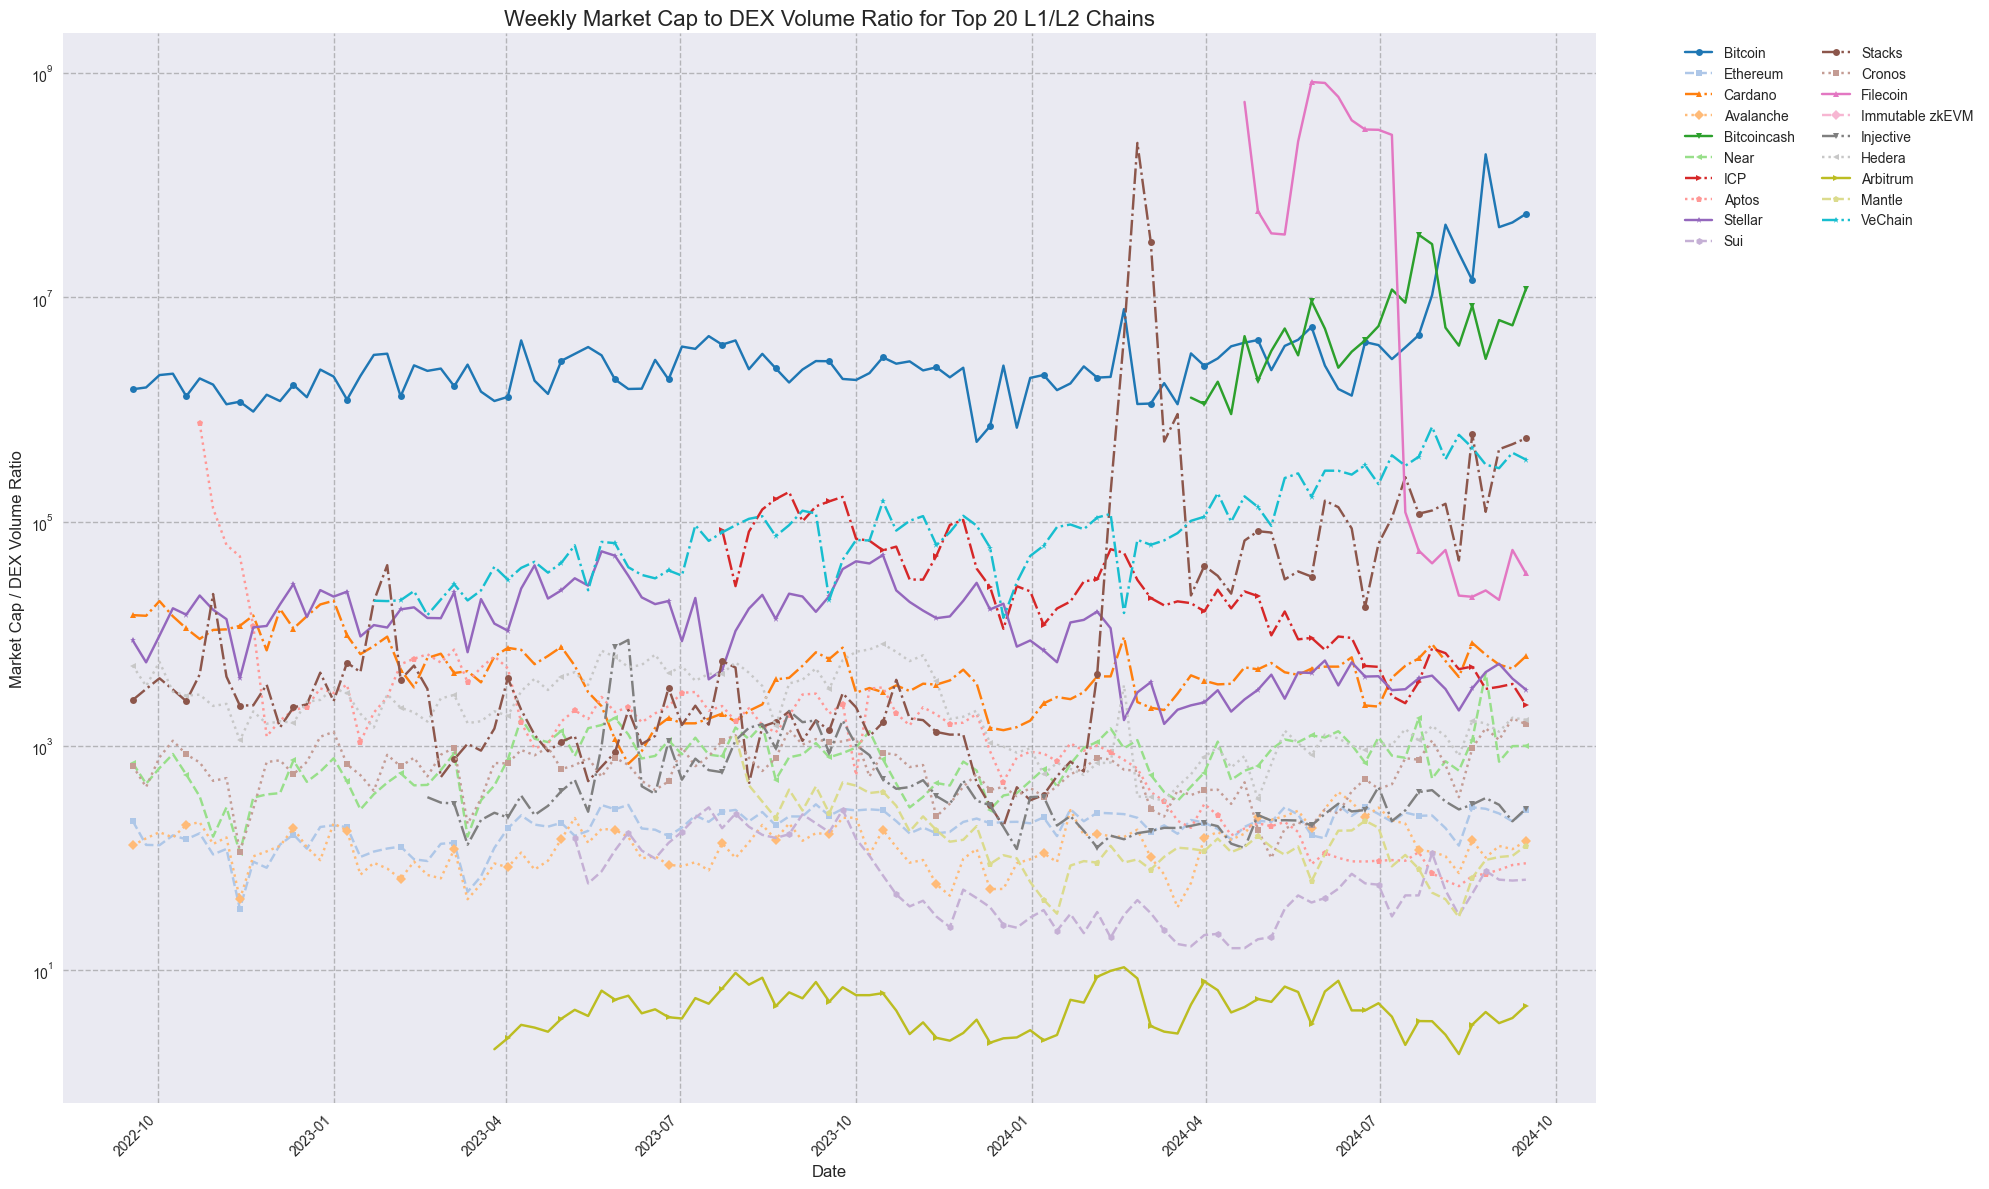

In [11]:
# Create a new figure with a larger size
plt.figure(figsize=(20, 12))

# Define a list of line styles, markers, and a colormap
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
colormap = plt.cm.get_cmap('tab20')  # 20 distinct colors

# Plot weekly data for each chain
for i, (chain, df) in enumerate(weekly_data.items()):
    plt.plot(df.index, df['mcap_volume_ratio'], 
             label=chain, 
             linestyle=line_styles[i % len(line_styles)],
             marker=markers[i % len(markers)],
             markersize=5,
             markevery=4,  # Plot marker every 4 data points
             color=colormap(i / len(weekly_data)))

# Customize the plot
plt.title('Weekly Market Cap to DEX Volume Ratio for Top 20 L1/L2 Chains', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Market Cap / DEX Volume Ratio', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, ncol=2)
plt.yscale('log')  # Use log scale for y-axis due to potential large differences
plt.grid(True, which="both", ls="--", c='gray', alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Time-adjusted Comparison of Aptos to Top 20 L1/L2 Chains

In this section, we'll perform a time-adjusted comparison of Aptos to the top 20 L1/L2 chains by TVL (Total Value Locked), DEX (Decentralized Exchange) volume, and stablecoin TVL. We'll align all data sources to start at t_0, regardless of their actual start date, to provide a fair comparison of growth and trends.

## Charts Explanation

We'll create three charts:

1. TVL Comparison
2. DEX Volume Comparison
3. Stablecoin TVL Comparison

Each chart will show the time-adjusted data for Aptos and the other top chains, allowing us to compare their growth trajectories from a common starting point.

## Analysis

By comparing Aptos to other established chains from a time-adjusted perspective, we can assess:

1. How quickly Aptos has grown in terms of TVL, DEX volume, and stablecoin adoption compared to other chains at similar stages of their development.
2. Whether Aptos shows any unique growth patterns or adoption rates that differentiate it from other chains.
3. The relative strength of Aptos in different areas (e.g., general TVL vs. DEX activity vs. stablecoin usage) compared to its competitors.

This analysis will help answer the question: How does Aptos' growth and adoption compare to other top L1/L2 chains when accounting for their different launch dates?


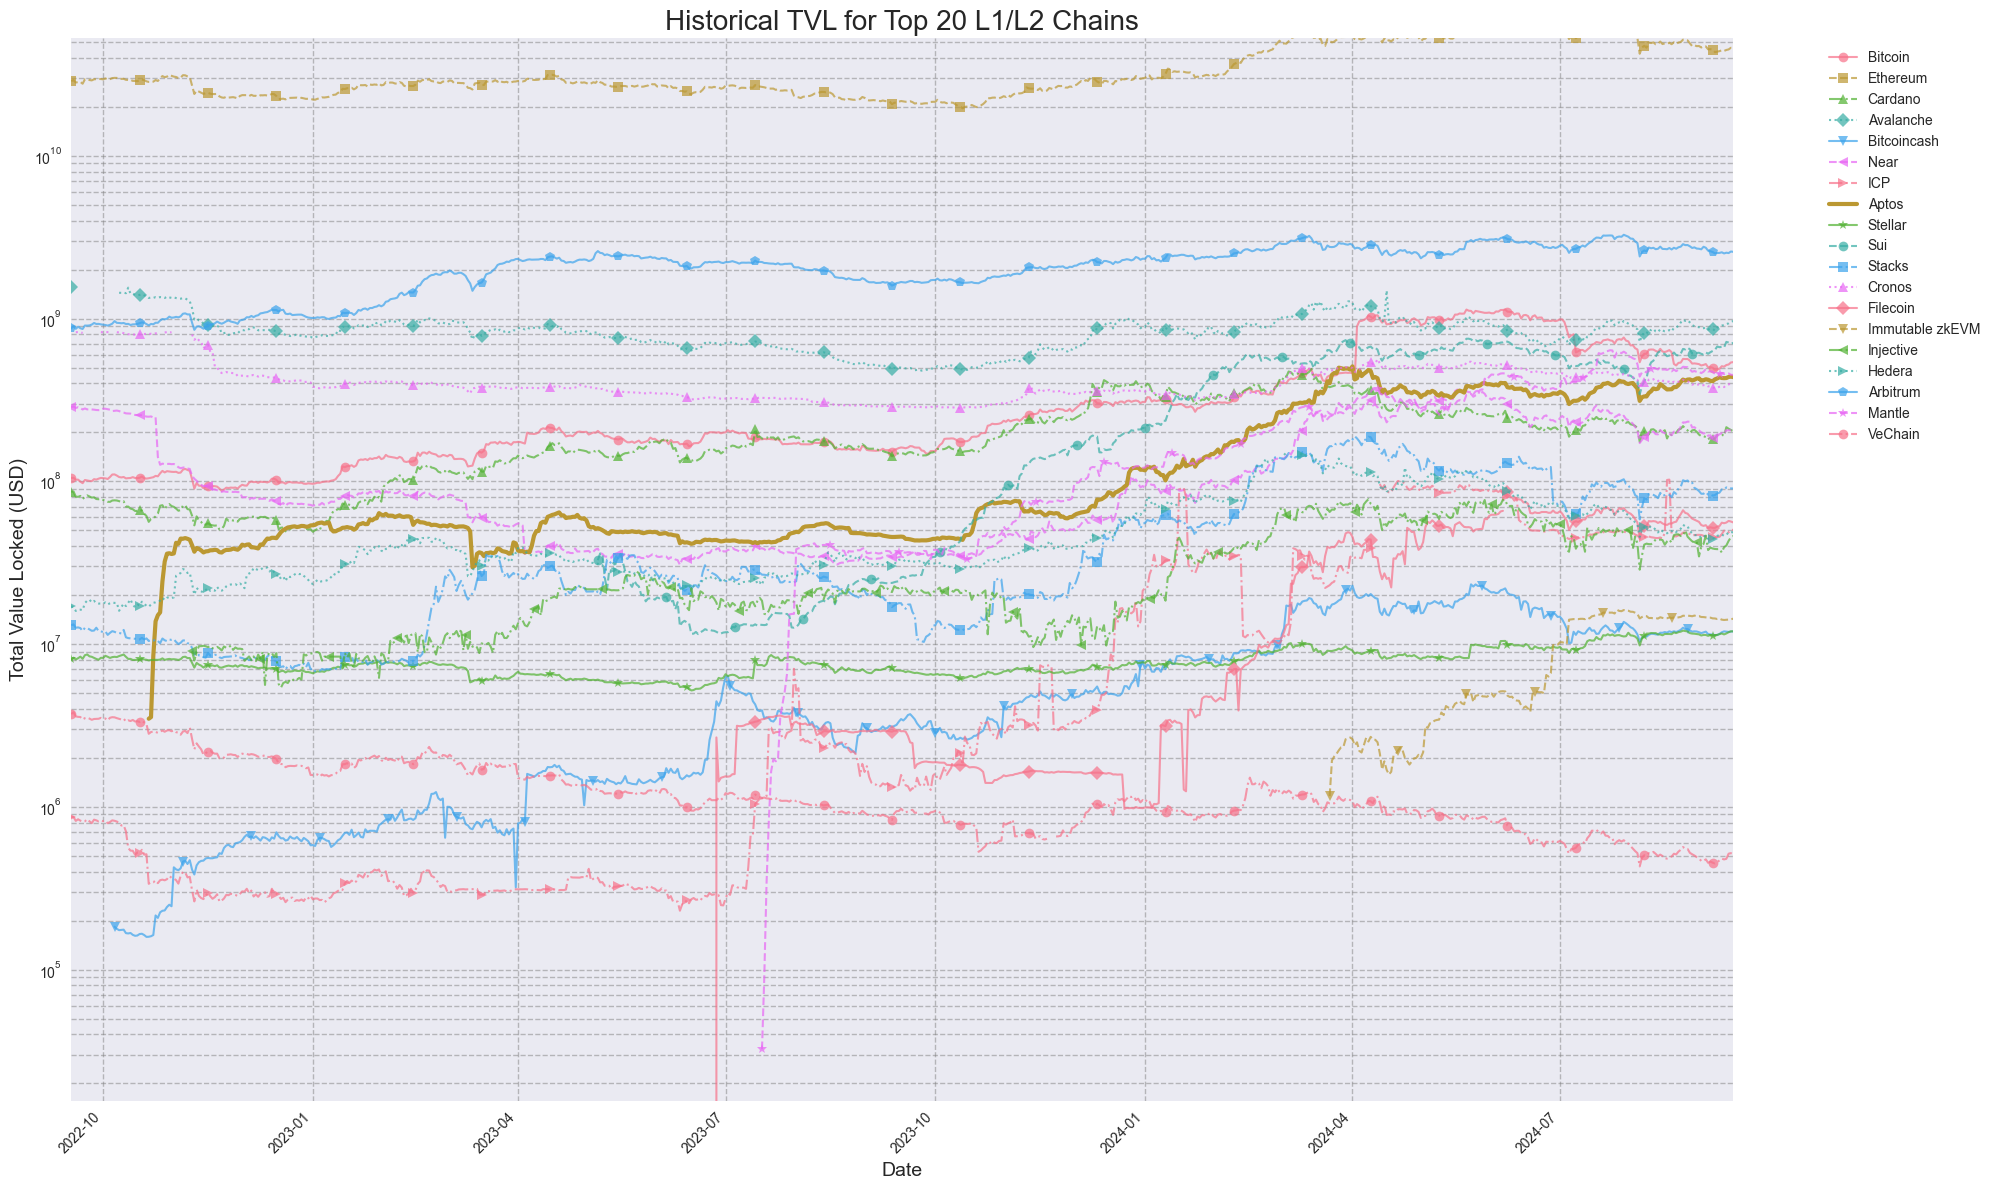

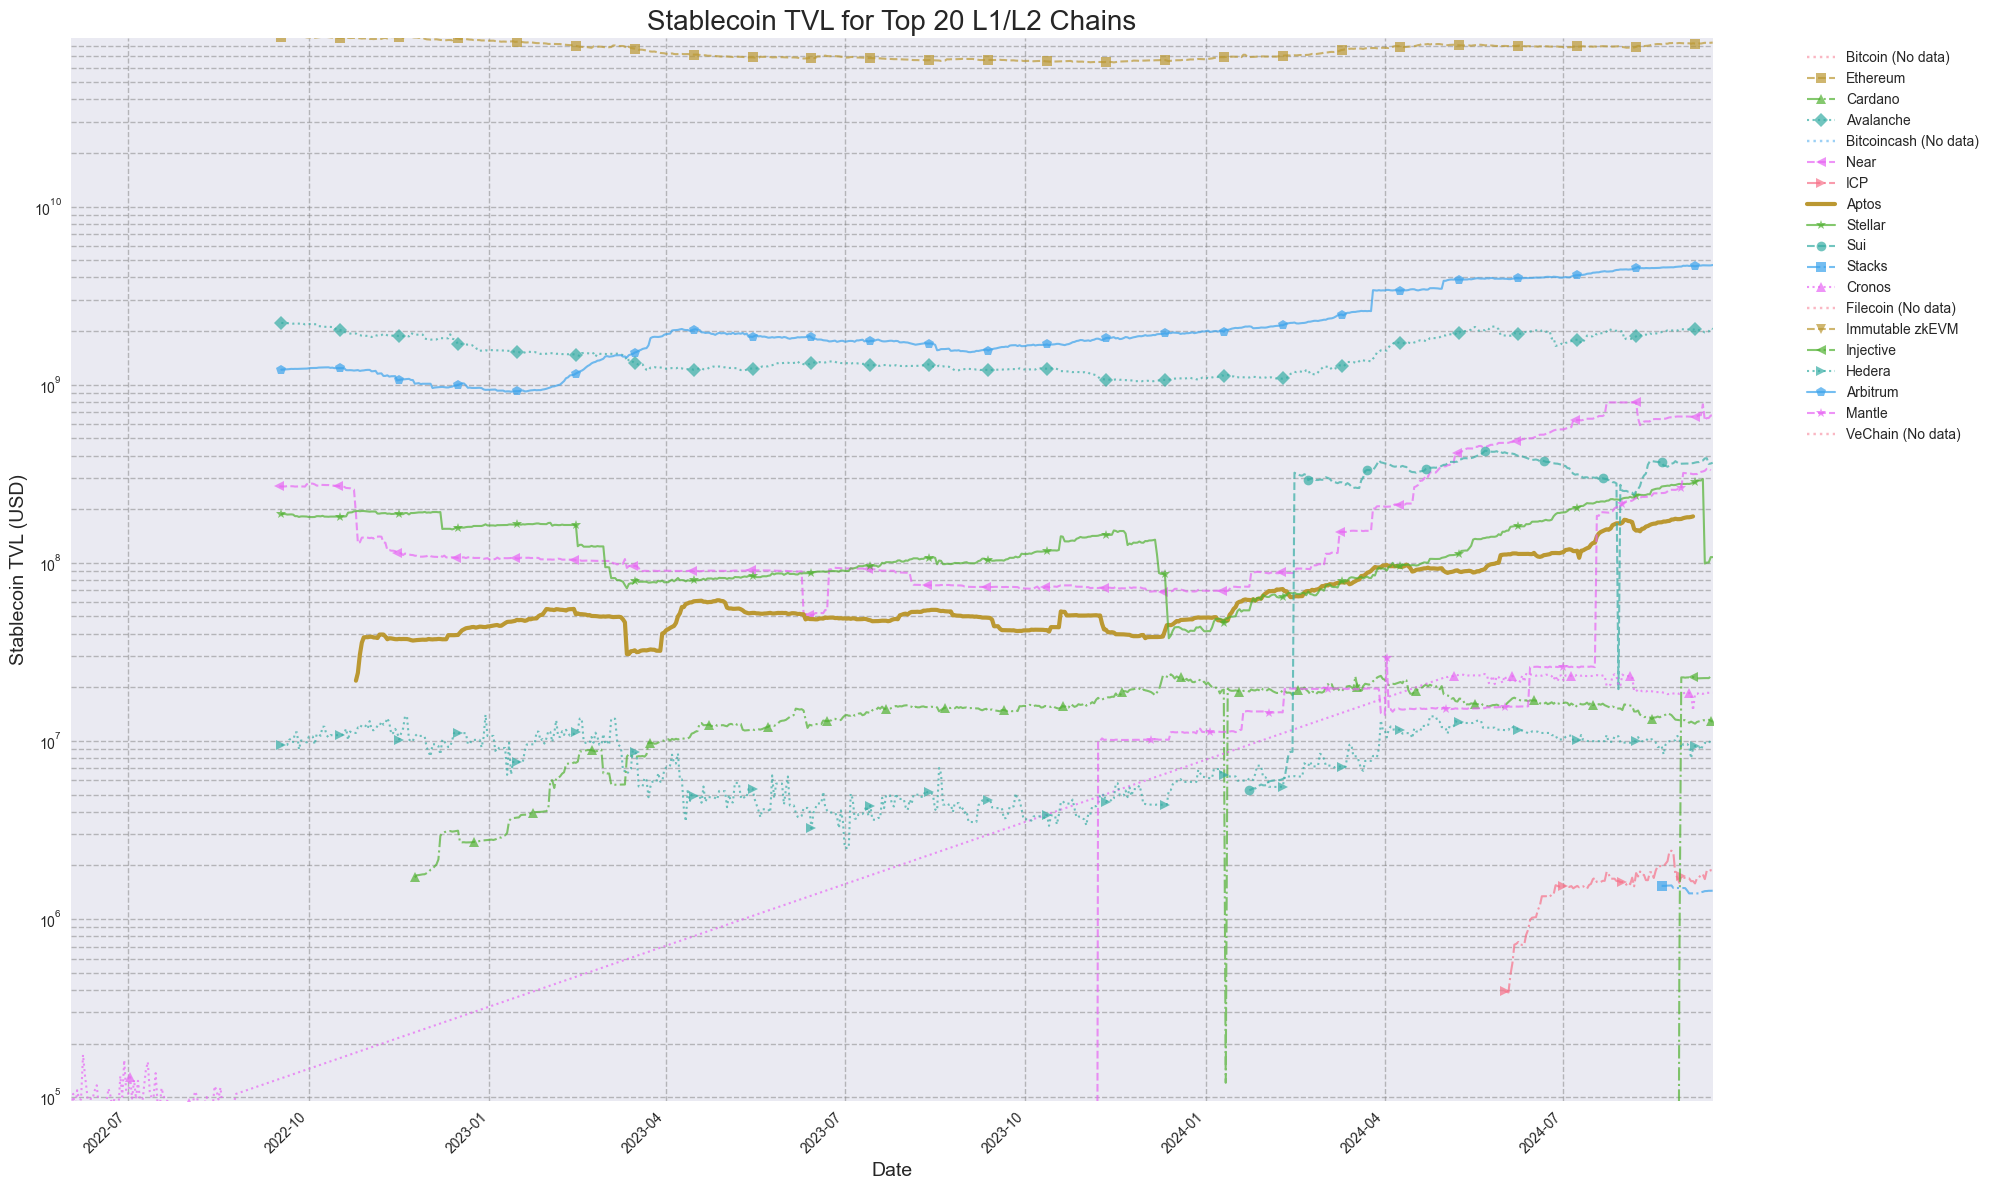

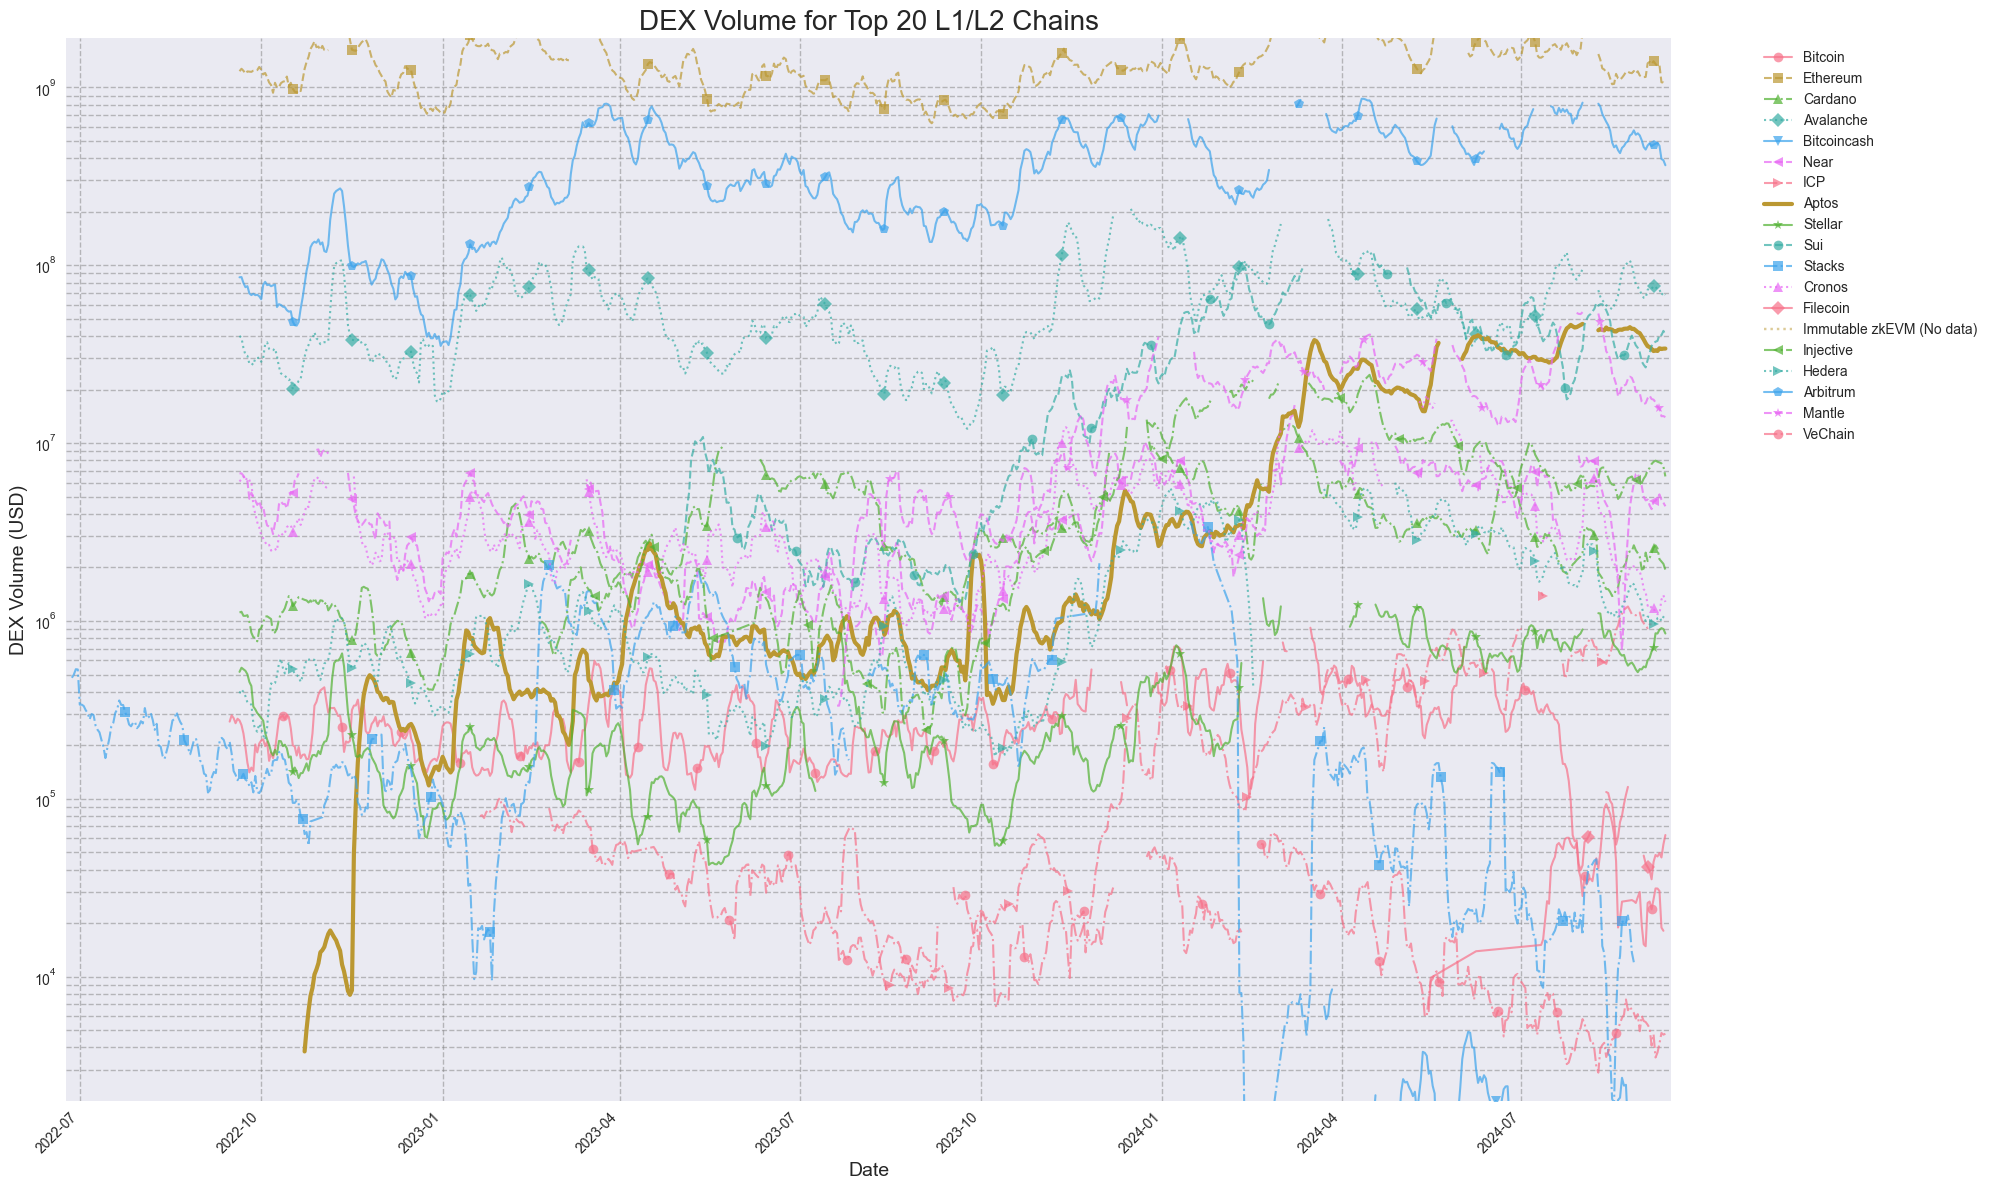

In [12]:
def remove_outliers(series, n_std=3):
    mean = np.mean(series)
    std = np.std(series)
    return series[(series > mean - n_std * std) & (series < mean + n_std * std)]

def plot_data(data_dict, title, y_label, highlight_chain='Aptos', smooth=False, window=7):
    plt.figure(figsize=(20, 12))
    
    # Create a list of line styles and markers for variety
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*']
    
    # Calculate overall min and max for y-axis limits
    all_values = []
    for df in data_dict.values():
        if df is not None and not df.empty:
            df_clean = remove_outliers(df.iloc[:, 0])
            if smooth:
                df_clean = df_clean.rolling(window=window, center=True).mean()
            all_values.extend(df_clean.dropna().tolist())
    
    if all_values:
        y_min, y_max = np.percentile(all_values, [1, 99])
    else:
        y_min, y_max = 0, 1  # Default values if no data
    
    for i, (chain, df) in enumerate(data_dict.items()):
        if df is None or df.empty:
            plt.plot(pd.date_range(start='2021-01-01', end='2023-01-01'), 
                     np.zeros(731), 
                     label=f"{chain} (No data)",
                     linestyle=':', 
                     alpha=0.5)
        else:
            # Remove outliers and smooth data if required
            df_clean = df.copy()
            df_clean.iloc[:, 0] = remove_outliers(df_clean.iloc[:, 0])
            if smooth:
                df_clean = df_clean.rolling(window=window, center=True).mean()
            
            if chain.lower() == highlight_chain.lower():
                plt.plot(df_clean.index, df_clean.iloc[:, 0], linewidth=3, label=chain)
            else:
                line_style = line_styles[i % len(line_styles)]
                marker = markers[i % len(markers)]
                plt.plot(df_clean.index, df_clean.iloc[:, 0], 
                         alpha=0.7, 
                         linewidth=1.5, 
                         label=chain, 
                         linestyle=line_style,
                         marker=marker,
                         markevery=30)  # Add marker every 30 data points
    
    plt.title(title, fontsize=20)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.yscale('log')
    plt.ylim(y_min, y_max)  # Set y-axis limits
    plt.grid(True, which="both", ls="--", c='gray', alpha=0.5)
    plt.xticks(rotation=45, ha='right')
    
    # Adjust x-axis limits to show only the period with data
    non_empty_dfs = [df for df in data_dict.values() if df is not None and not df.empty]
    if non_empty_dfs:
        x_min = min(df.index.min() for df in non_empty_dfs)
        x_max = max(df.index.max() for df in non_empty_dfs)
        plt.xlim(x_min, x_max)
    
    plt.tight_layout()
    plt.show()

# Plot Historical TVL
plot_data(historical_tvl_by_chain, 'Historical TVL for Top 20 L1/L2 Chains', 'Total Value Locked (USD)')

# Plot Stablecoin TVL
plot_data(stablecoin_tvl_by_chain, 'Stablecoin TVL for Top 20 L1/L2 Chains', 'Stablecoin TVL (USD)')

# Plot DEX Volume with smoothing
plot_data(dex_volume_by_chain, 'DEX Volume for Top 20 L1/L2 Chains', 'DEX Volume (USD)', smooth=True, window=7)

# Correlation Analysis Methodology and Results

## Methodology

1. Data Preparation:
   - We use price data for the top 20 L1/L2 chains over the past 24 months.
   - The data is resampled to daily frequency and forward-filled to ensure consistency.

2. Correlation Calculation:
   - We compute a 15-day rolling correlation between each token and Ethereum.
   - This captures short-term correlation dynamics while smoothing out daily noise.

3. Low Correlation Period Identification:
   - We define low correlation as periods where the absolute correlation is below 0.3.
   - This threshold captures both negative and weak positive correlations.

4. Analysis of Low Correlation Periods:
   - For each identified period, we calculate:
     a) Duration of the low correlation period
     b) Start and end dates
     c) Relative volatility of the token vs ETH during this period
     d) Relative volatility of ETH vs its own volatility in the prior 24 months

5. Results Compilation:
   - The results are sorted to show the lowest correlation periods first.

## Results Interpretation

The results from this analysis will show:

1. Which tokens have had the lowest correlations with Ethereum
2. How long these low correlation periods lasted
3. When these periods occurred
4. How volatile these tokens were compared to ETH during these periods
5. How ETH's volatility during these periods compared to its historical volatility

This information is valuable for:
- Identifying potential diversification opportunities
- Understanding market dynamics and relationships between different L1/L2 platforms
- Spotting periods of decoupling between major cryptocurrencies and smaller tokens

The full results of this analysis will be displayed in the output of the next cell.


In [13]:
def analyze_correlations(price_market_cap_by_chain, top_20_l1l2_names, window=15, months=24, low_corr_threshold=0.3):
    end_date = pd.Timestamp.now()
    start_date = end_date - pd.DateOffset(months=months)
    
    # Prepare price data
    price_data = {}
    for chain in top_20_l1l2_names:
        if chain in price_market_cap_by_chain:
            df = price_market_cap_by_chain[chain]
            price_data[chain] = df['price'].loc[start_date:end_date]
    
    # Combine price data into a single DataFrame
    price_df = pd.DataFrame(price_data)
    
    # Ensure all columns have the same index
    price_df = price_df.resample('D').last().ffill()
    
    # Compute correlations against Ethereum
    eth_price = price_df['Ethereum']
    correlations = price_df.rolling(window).corr(eth_price)
    
    # Analyze low correlation periods
    low_corr_results = []
    for token in correlations.columns:
        if token == 'Ethereum':
            continue
        
        token_corr = correlations[token]
        low_corr = token_corr.abs() < low_corr_threshold  # Use absolute correlation
        if low_corr.any():
            low_corr_periods = low_corr.astype(int).diff().ne(0).cumsum()[low_corr]
            for period, group in low_corr_periods.groupby(low_corr_periods):
                start = group.index[0]
                end = group.index[-1]
                duration = (end - start).days
                
                # Calculate relative volatility
                token_returns = price_df[token].pct_change().loc[start:end]
                eth_returns = eth_price.pct_change().loc[start:end]
                relative_volatility = token_returns.std() / eth_returns.std()
                
                # Calculate ETH volatility relative to prior 24 months
                prior_start = start - pd.DateOffset(months=24)
                prior_eth_returns = eth_price.pct_change().loc[prior_start:start]
                eth_relative_volatility = eth_returns.std() / prior_eth_returns.std()
                
                low_corr_results.append({
                    'token': token,
                    'start_date': start,
                    'end_date': end,
                    'duration': duration,
                    'correlation': token_corr.loc[start:end].mean(),
                    'relative_volatility': relative_volatility,
                    'eth_relative_volatility': eth_relative_volatility
                })
    
    # Sort results by absolute correlation (ascending) and duration (descending)
    low_corr_results = sorted(low_corr_results, key=lambda x: (abs(x['correlation']), -x['duration']))
    
    return low_corr_results

# Run the analysis
low_correlation_periods = analyze_correlations(price_market_cap_by_chain, top_20_l1l2_names)

# Print the results
print("Tokens with lowest absolute correlations vs Ethereum:")
for result in low_correlation_periods[:20]:  # Print top 20 results
    print(f"Token: {result['token']}")
    print(f"  Absolute Correlation: {abs(result['correlation']):.4f}")
    print(f"  Actual Correlation: {result['correlation']:.4f}")
    print(f"  Duration: {result['duration']} days")
    print(f"  Period: {result['start_date'].date()} to {result['end_date'].date()}")
    print(f"  Relative Volatility (Token vs ETH): {result['relative_volatility']:.4f}")
    print(f"  ETH Relative Volatility (vs Prior 24 Months): {result['eth_relative_volatility']:.4f}")
    print()

Tokens with lowest absolute correlations vs Ethereum:
Token: Avalanche
  Absolute Correlation: 0.0009
  Actual Correlation: -0.0009
  Duration: 6 days
  Period: 2023-11-25 to 2023-12-01
  Relative Volatility (Token vs ETH): 1.6693
  ETH Relative Volatility (vs Prior 24 Months): 0.4471

Token: ICP
  Absolute Correlation: 0.0019
  Actual Correlation: -0.0019
  Duration: 16 days
  Period: 2024-01-03 to 2024-01-19
  Relative Volatility (Token vs ETH): 2.0092
  ETH Relative Volatility (vs Prior 24 Months): 1.3142

Token: Hedera
  Absolute Correlation: 0.0026
  Actual Correlation: -0.0026
  Duration: 8 days
  Period: 2023-07-22 to 2023-07-30
  Relative Volatility (Token vs ETH): 1.6768
  ETH Relative Volatility (vs Prior 24 Months): 0.3651

Token: Avalanche
  Absolute Correlation: 0.0027
  Actual Correlation: 0.0027
  Duration: 3 days
  Period: 2024-03-16 to 2024-03-19
  Relative Volatility (Token vs ETH): 1.7394
  ETH Relative Volatility (vs Prior 24 Months): 1.9682

Token: Hedera
  Absolut